In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [176]:
# General libraries for easy data manipulation
import os  
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
# Scientific computing libraries
import scipy.constants as scp
import astropy.constants as asc
from sklearn.preprocessing import normalize
# Plotting libraries and methods
import matplotlib.pyplot as plt
#<< Import more libraries as needed >>

In [177]:
data=pd.read_csv("C11_1024_Packets_B3.out",names=['c11'])
data.shape

(4194304, 1)

In [178]:
data["c12"]=pd.read_csv("C12_1024_Packets_B3.out")
data['c12'] = data['c12'].fillna(0)
data.tail()


,c11,c12
4194299,-54,5.0
4194300,-52,6.0
4194301,-10,-16.0
4194302,-53,-11.0
4194303,48,0.0


In [179]:
meanc11=np.mean(data.c11)
meanc12=np.mean(data.c12)
stdc11=np.std(data.c11)
stdc12=np.std(data.c12)
print(meanc11,meanc12,stdc11,stdc12)
data['c11_centerd']=data.c11-meanc11
data['c12_centerd']=data.c12-meanc12

-1.0569393634796143 -1.0581026077270508 21.385557014213084 21.462582100006845


In [180]:
#t=pd.timedelta_range(0,periods=4194304,freq='2N')
data['time']=np.arange(0,0.01048576,2.5e-9)

In [181]:
data.head()

,c11,c12,c11_centerd,c12_centerd,time
0,-22,-3.0,-20.943061,-1.941897,0.000000e+00
1,1,2.0,2.056939,3.058103,2.500000e-09
2,-60,-16.0,-58.943061,-14.941897,5.000000e-09
3,-58,22.0,-56.943061,23.058103,7.500000e-09
4,54,-13.0,55.056939,-11.941897,1.000000e-08


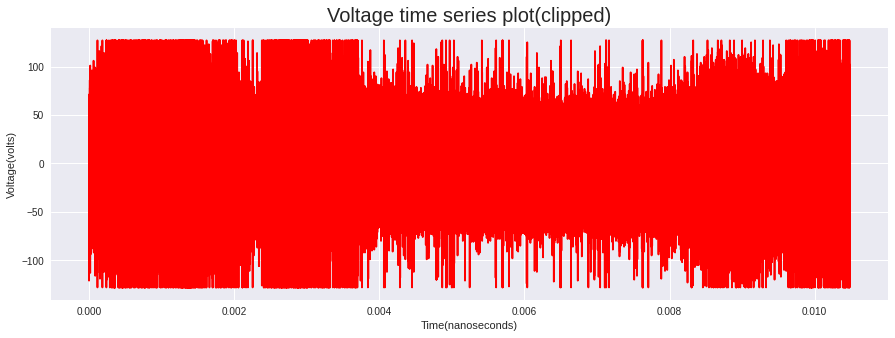

In [182]:
plt.style.use('seaborn')
#plt.style.use('dark_background')

plt.figure(figsize=[15,5])
plt.plot(data.time,data.c11,color='Red')
#plt.plot(volts['time'][0:150],volts['AS'][0:150],color='Blue')
plt.xlabel('Time(nanoseconds)')
plt.ylabel('Voltage(volts)')




plt.title('Voltage time series plot(clipped)',fontdict={'fontsize':20})
#plt.savefig('voltage_timeseries(clipped).png')
plt.show()

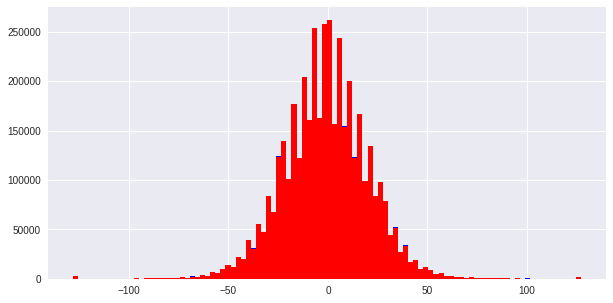

In [183]:
plt.figure(figsize=[10,5])
plt.hist(x=data.c12,bins=100, color='blue')

plt.hist(x=data.c11,bins=100, color='red')
plt.show()

In [184]:
data['Powerc11']=np.square(data.c11)
data['Powerc12']=np.square(data.c12)


/home/vysakh/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

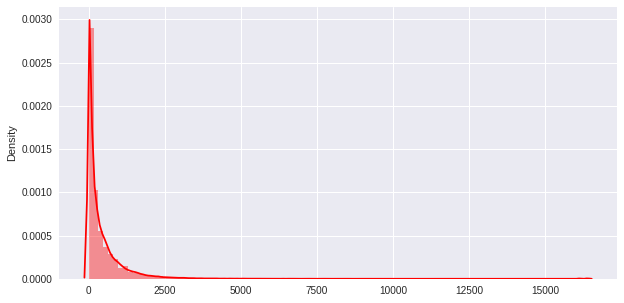

In [185]:
plt.figure(figsize=[10,5])
sns.distplot(x=data.Powerc11,bins=100, color='red')

# Dynamic Spectrum

In [229]:
fmax = 200*10**6 # Equals the bandwidth upper-limit of 16.5 MHz
print('Total bandwidth of signal = {0:.1f} MHz'.format(fmax/1e6))
dt = 1/(2*fmax) # Time resolution of 1/(33 MHz) seconds
print('Time-resolution of voltage sampling = {0:.2f} nanosecond'.format(dt*1e9))

Total bandwidth of signal = 200.0 MHz
Time-resolution of voltage sampling = 2.50 nanosecond


In [230]:
C11data=np.array(data.c11_centerd)
C12data=np.array(data.c12_centerd)
volt=C11data
volt2=C12data
Nfft=512
Nvolts=len(volt)
print("North Antenna voltage array shape:",C11data.shape)

# Reshare the voltage time-series to prepare it for taking the N-point Fourier transform
dim1=Nvolts//Nfft
dim2=len(volt2)//Nfft

volts_re=np.reshape(volt, (dim1,Nfft))
volts_reC12=np.reshape(volt2, (dim2,Nfft))

print("Reshaped array:",volts_re.shape)

# Obtain the Fourier transform and the frequency list
volts_fftC11=np.fft.rfft(volts_re)
volts_fftC12=np.fft.rfft(volts_reC12)
n=volts_re.shape[1]

# Calculate the absolute value squared for the FFT output to obtain the power spectral density
Power_spectra= np.square(np.absolute(volts_fftC11))

# Add Nint set of consecutive spectra to obtain the final dynamic spectrum
Nint=16
Power_spec_cons=np.empty([dim1//Nint,volts_fftC11.shape[1]])
for i in range(0,dim1//Nint):
    var=0
    for j in range(0,Nint):
        var += Power_spectra[j+(i*Nint)]
    Power_spec_cons[i]=var/Nint
print("Final Power Spectra:",Power_spec_cons.shape)

North Antenna voltage array shape: (4194304,)
Reshaped array: (8192, 512)
Final Power Spectra: (512, 257)


In [231]:
timeplt=np.arange(0,0.01048576,(10485.76/(Power_spec_cons.shape[0]))*1e-6)*1e3
norm=normalize(Power_spec_cons)
norm_trans=norm.transpose()
volts_freq=(np.fft.rfftfreq(n,d=dt)*1e-6)
#volts_freq=sorted(volts_freq,reverse=True)

/home/vysakh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


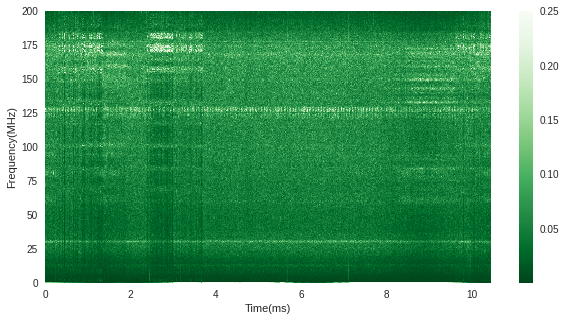

In [232]:
plt.figure(figsize=[10,5])
plt.pcolormesh(timeplt,volts_freq,norm_trans, cmap='Greens_r',vmax=0.25)
plt.colorbar()
plt.xlabel('Time(ms)')
plt.ylabel('Frequency(MHz)')
plt.savefig('Spectra.png')


Text(0.5, 0, 'mean power spectrum')

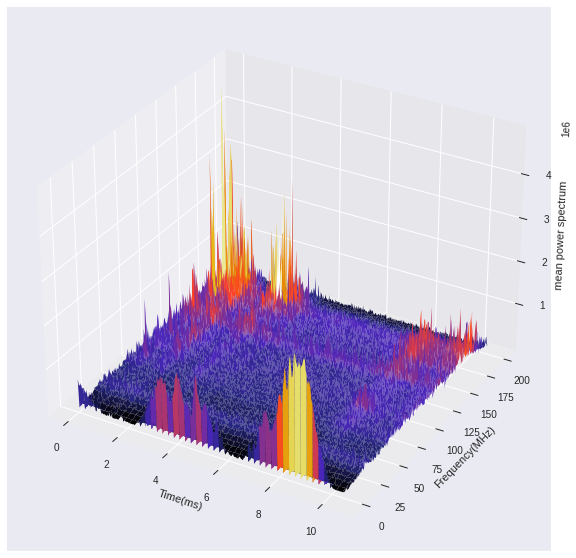

In [253]:
X,Y = np.meshgrid(timeplt,volts_freq)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Power_spec_cons.transpose(),cmap='CMRmap')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Frequency(MHz)')
ax.set_zlabel('mean power spectrum')

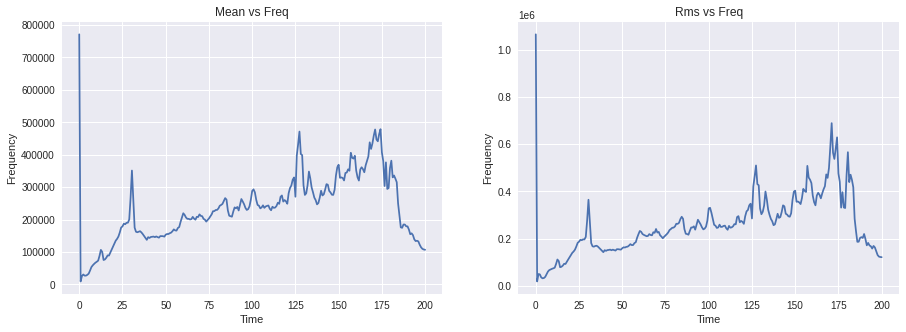

In [233]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[15,5])
Power_mean=np.mean(Power_spec_cons,axis=0)
ax1.plot(volts_freq,Power_mean)

Power_rms=np.mean(Power_spec_cons**2,axis=0)
ax2.plot(volts_freq,np.sqrt(Power_rms))
ax1.set_title("Mean vs Freq")
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax2.set_title("Rms vs Freq")
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
plt.show()
#plt.plot(volts_freq,(Power_mean/np.sqrt(1*)))

In [234]:
CRCOspectra=np.abs(volts_fftC11*np.conjugate(volts_fftC12))
Nint=16
CRCO_spec_cons=np.empty([dim1//Nint,CRCOspectra.shape[1]])
n=volts_re.shape[1]

for i in range(0,dim1//Nint):
    var=0
    for j in range(0,Nint):
        var += CRCOspectra[j+(i*Nint)]
    CRCO_spec_cons[i]=var/Nint
print("Final Power Spectra:",CRCO_spec_cons.shape)

Final Power Spectra: (512, 257)


In [235]:
CRCO_spec_cons

array([[652976.81212336,   3199.07042021,   9884.10103021, ...,
         63913.46439364,  68444.82732343,  49636.8125    ],
       [602709.01171595,   1860.4450821 ,   9066.27737409, ...,
         97561.79909201,  71957.30961505,  65038.6875    ],
       [565285.61112696,   3113.98883266,   8816.47849448, ...,
         61400.5448325 ,  59707.82428866,  47365.8125    ],
       ...,
       [ 33851.78095356,   6132.72336034,  25951.15507253, ...,
        165440.8880014 ,  84782.26340345, 110657.4375    ],
       [ 35330.8046594 ,  32476.41051489,  62759.05335075, ...,
        136572.59891293, 109318.33874455,  85060.0625    ],
       [ 30768.71806446,  29421.22008167,  43539.75569002, ...,
        197444.9112019 , 130000.9401409 , 112226.6875    ]])

In [236]:
timepltCRCO=np.arange(0,0.01048576,(10485.76/(CRCO_spec_cons.shape[0]))*1e-6)*1e3
normCRCO=normalize(CRCO_spec_cons)
norm_transCRCO=normCRCO.transpose()
volts_freqCRCO=(np.fft.rfftfreq(n,d=dt))


/home/vysakh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vysakh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


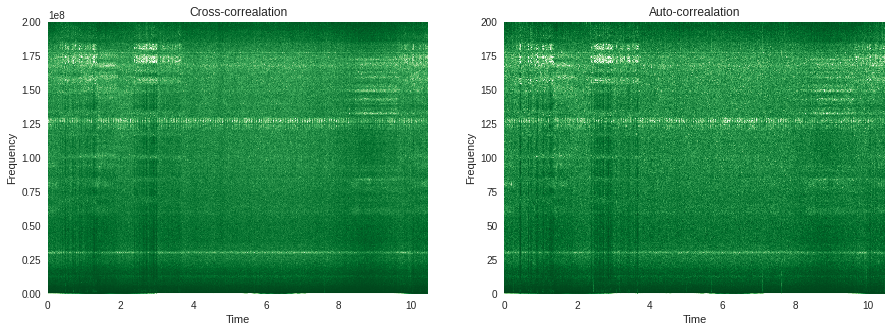

In [237]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[15,5])
#plt.figure(figsize=[10,5])
ax1.pcolormesh(timepltCRCO,volts_freqCRCO ,norm_transCRCO, cmap='Greens_r',vmax=0.25)
ax2.pcolormesh(timeplt,volts_freq,norm_trans, cmap='Greens_r',vmax=0.25)
#ax1.colorbar()
ax1.set_title("Cross-correalation")
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax2.set_title("Auto-correalation")
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
plt.savefig('Correlations.png')

# PHASE AND MAGNITUDE OF DATA



In [238]:
p=np.empty([len(data.c11)])
for i,v in enumerate(data.c11):
    #print(i,end=" ")
    if v>=0:
        p[i]=1
    else:
        p[i]=0


In [239]:
p.shape

(4194304,)

In [240]:
data['c11phase']=p

In [241]:
C11data=np.array(data.c11phase)
phase=C11data
Nfft=512
Nvolts=len(phase)
print("Phase array shape:",phase.shape)

# Reshare the voltage time-series to prepare it for taking the N-point Fourier transform
dim1=Nvolts//Nfft

phase_re=np.reshape(phase, (dim1,Nfft))
print("Reshaped array:",phase_re.shape)

# Obtain the Fourier transform and the frequency list
phase_fftC11=np.fft.rfft(phase_re)
n=phase_re.shape[1]

# Calculate the absolute value squared for the FFT output to obtain the power spectral density
phase_spectra= np.square(np.absolute(phase_fftC11))

# Add Nint set of consecutive spectra to obtain the final dynamic spectrum
Nint=16
phase_spec_cons=np.empty([dim1//Nint,phase_fftC11.shape[1]])
for i in range(0,dim1//Nint):
    var=0
    for j in range(0,Nint):
        var += phase_spectra[j+(i*Nint)]
    phase_spec_cons[i]=var/Nint
print("Final Phase Spectra:",phase_spec_cons.shape)

Phase array shape: (4194304,)
Reshaped array: (8192, 512)
Final Phase Spectra: (512, 257)


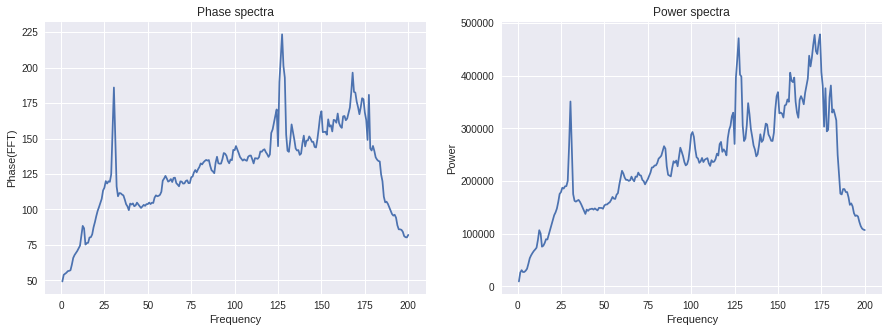

In [242]:
phase_mean=np.mean(phase_spec_cons,axis=0)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[15,5])
ax1.plot(volts_freq[1:257],phase_mean[1:257])
ax2.plot(volts_freq[1:257],Power_mean[1:257])

ax1.set_title('Phase spectra')
ax2.set_title('Power spectra')
ax1.set_xlabel("Frequency")
ax2.set_xlabel("Frequency")
ax1.set_ylabel("Phase(FFT)")
ax2.set_ylabel("Power")

plt.show()

In [243]:
timeplt=np.arange(0,0.01048576,(10485.76/(Power_spec_cons.shape[0]))*1e-6)*1e3
norm=normalize(phase_spec_cons)
norm_trans=norm.transpose()
volts_freq=(np.fft.rfftfreq(n,d=dt)*1e-6)

In [244]:
norm_trans[1:257].shape

(256, 512)

/home/vysakh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


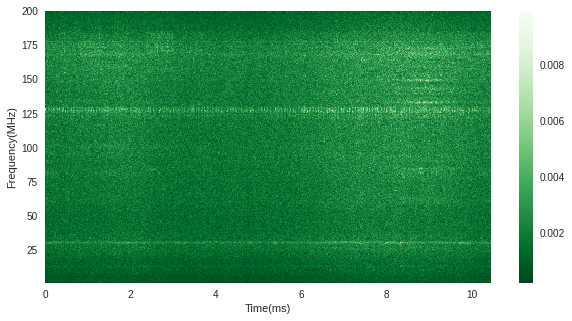

In [245]:
plt.figure(figsize=[10,5])
plt.pcolormesh(timeplt,volts_freq[1:257],norm_trans[1:257], cmap='Greens_r')
plt.colorbar()
plt.xlabel('Time(ms)')
plt.ylabel('Frequency(MHz)')
plt.savefig('Spectra.png')


In [246]:
C11data=np.abs(np.array(data.c11_centerd))
mag=C11data
Nfft=512
Nvolts=len(mag)
print("Magnitude array shape:",mag.shape)

# Reshare the voltage time-series to prepare it for taking the N-point Fourier transform
dim1=Nvolts//Nfft

mag_re=np.reshape(mag, (dim1,Nfft))
print("Reshaped array:",mag_re.shape)

# Obtain the Fourier transform and the frequency list
mag_fftC11=np.fft.rfft(mag_re)
n=mag_re.shape[1]

# Calculate the absolute value squared for the FFT output to obtain the power spectral density
mag_spectra= np.square(np.absolute(mag_fftC11))

# Add Nint set of consecutive spectra to obtain the final dynamic spectrum
Nint=16
mag_spec_cons=np.empty([dim1//Nint,mag_fftC11.shape[1]])
for i in range(0,dim1//Nint):
    var=0
    for j in range(0,Nint):
        var += mag_spectra[j+(i*Nint)]
    mag_spec_cons[i]=var/Nint
print("Final Magnitude Spectra:",mag_spec_cons.shape)

Magnitude array shape: (4194304,)
Reshaped array: (8192, 512)
Final Magnitude Spectra: (512, 257)


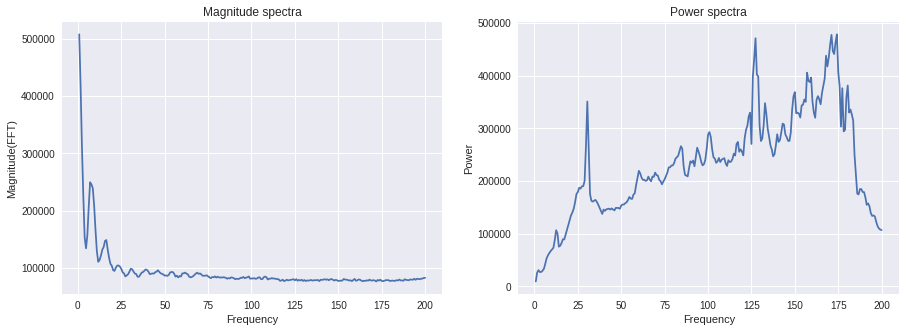

In [247]:
mag_mean=np.mean(mag_spec_cons,axis=0)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[15,5])
ax1.plot(volts_freq[1:257],mag_mean[1:257])
ax2.plot(volts_freq[1:257],Power_mean[1:257])

ax1.set_title('Magnitude spectra')
ax2.set_title('Power spectra')
ax1.set_xlabel("Frequency")
ax2.set_xlabel("Frequency")
ax1.set_ylabel("Magnitude(FFT)")
ax2.set_ylabel("Power")

plt.show()